In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np


In [15]:
dataset_path =r"C:\Users\vakas\OneDrive\Desktop\vs code peojects\AI Generated Faces Dataset\AI-face-detection-Dataset"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")

IMG_SIZE = 224  # ResNet-50 input size
BATCH_SIZE = 32

# Function to convert images to grayscale
def grayscale_preprocessing(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert back to 3 channels (needed for ResNet)
    return image


In [16]:
# ImageDataGenerator with preprocessing function
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=grayscale_preprocessing,
    validation_split=0.2  # 80% train, 20% validation split
)

# Training Data Loader
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# Validation Data Loader
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)


Found 2564 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


In [17]:
# Load ResNet-50 with ImageNet weights, removing the top layers
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classifier layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)  # Binary classification (Fake vs. Real)

# Create final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [22]:
EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


c:\Users\vakas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 470s 6s/step - accuracy: 0.6510 - loss: 0.6020 - val_accuracy: 0.8797 - val_loss: 0.3341
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 492s 6s/step - accuracy: 0.9075 - loss: 0.2452 - val_accuracy: 0.9438 - val_loss: 0.1630
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 399s 5s/step - accuracy: 0.9646 - loss: 0.1121 - val_accuracy: 0.9656 - val_loss: 0.1034
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 419s 5s/step - accuracy: 0.9661 - loss: 0.1024 - val_accuracy: 0.8953 - val_loss: 0.2530
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 393s 5s/step - accuracy: 0.9439 - loss: 0.1322 - val_accuracy: 0.9844 - val_loss: 0.0529
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 344s 4s/step - accuracy: 0.9852 - loss: 0.0484 - val_accuracy: 0.9828 - val_loss: 0.0497
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.9863 - loss: 0.0472 - val_accuracy: 0.9391 - val_loss: 0.1616
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 344s 4s/step - accuracy: 0.9789 - loss: 0.0562 - val_accuracy: 0.9859 - v

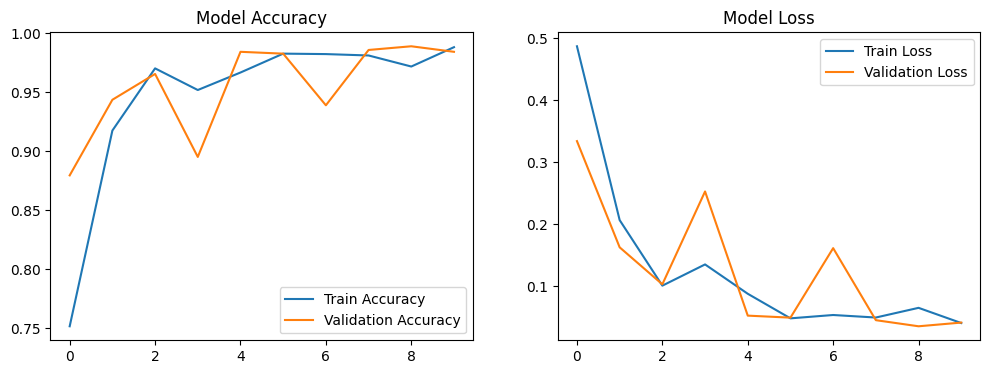

In [23]:
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [24]:
model.save("deepfake_detector_resnet50.h5")


In [20]:
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert back to 3 channels
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)

    if prediction > 0.5:
        print("Real Image")
    else:
        print("Fake Image")

# Test with a new image
predict_image(r"c:\Users\vakas\OneDrive\Pictures\Camera Roll\WIN_20250406_19_38_53_Pro.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Real Image
